<h1 style='color:orange; font-weight:bold; text-align:center'>WORK SPACE</h1>

In Windows, use kernel 3.10.5 for running tensorflow

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix

## **1 Data Preparation**

### **1.1 Data Import**

In [ ]:
# load dataset
df = pd.read_csv('../data/cleaned_data.csv', parse_dates=True)
df.head()

,Category,ProductName,Location,Price,OverallRating,NumberSold,TotalReview,CustomerRating,CustomerReview,Sentiment,Emotion,tokens,CleanReview
0,Computers and Laptops,Wireless Keyboard i8 Mini TouchPad Mouse 2.4G ...,Jakarta Utara,53500,4.9,5449,2369,5,Alhamdulillah berfungsi dengan baik. Packaging...,Positive,Happy,"['alhamdulillah', 'berfungsi', 'packaging', 'a...",alhamdulillah berfungsi dengan baik packaging ...
1,Computers and Laptops,PAKET LISENSI WINDOWS 10 PRO DAN OFFICE 2019 O...,Kota Tangerang Selatan,72000,4.9,2359,1044,5,"barang bagus dan respon cepat, harga bersaing ...",Positive,Happy,"['barang', 'bagus', 'respon', 'cepat', 'harga'...",barang bagus dan respon cepat harga bersaing d...
2,Computers and Laptops,SSD Midasforce 128 Gb - Tanpa Caddy,Jakarta Barat,213000,5.0,12300,3573,5,"barang bagus, berfungsi dengan baik, seler ram...",Positive,Happy,"['barang', 'bagus', 'berfungsi', 'seler', 'ram...",barang bagus berfungsi dengan baik seler ramah...
3,Computers and Laptops,ADAPTOR CHARGER MONITOR LCD LED TV LG merek LG...,Jakarta Timur,55000,4.7,2030,672,5,bagus sesuai harapan penjual nya juga ramah. t...,Positive,Happy,"['bagus', 'sesuai', 'harapan', 'penjual', 'ram...",bagus sesuai harapan penjual nya juga ramah tr...
4,Computers and Laptops,ADAPTOR CHARGER MONITOR LCD LED TV LG merek LG...,Jakarta Timur,55000,4.7,2030,672,5,"Barang Bagus, pengemasan Aman, dapat Berfungsi...",Positive,Happy,"['barang', 'bagus', 'pengemasan', 'aman', 'ber...",barang bagus pengemasan aman dapat berfungsi d...


In [ ]:
# function to inspect dataframe
def inspect_dataframe(df):
    summary = {
        'ColumnName': df.columns.values.tolist(),
        'Nrow': df.shape[0],
        'DataType': df.dtypes.values.tolist(),
        'NAPct': (df.isna().mean()*100).round(2).tolist(),
        'DuplicatePct': (df.duplicated().sum()/len(df)*100).round(2),
        'UniqueValues': df.nunique().tolist(),
        'Sample': [df[col].unique() for col in df.columns]
    }
    return pd.DataFrame(summary)

In [ ]:
# inspect dataframe
print(f'The dataframe contains {df.shape[0]} rows and {df.shape[1]} cols')
print(f"- {len(df.select_dtypes(include='number').columns)} are numeric cols")
print(f"- {len(df.select_dtypes(include='O').columns)} are object cols")
inspect_dataframe(df)

The dataframe contains 5393 rows and 13 cols
- 5 are numeric cols
- 8 are object cols


,ColumnName,Nrow,DataType,NAPct,DuplicatePct,UniqueValues,Sample
0,Category,5393,object,0.0,0.0,29,"[Computers and Laptops, Toys and Hobbies, Food..."
1,ProductName,5393,object,0.0,0.0,1308,[Wireless Keyboard i8 Mini TouchPad Mouse 2.4G...
2,Location,5393,object,0.0,0.0,61,"[Jakarta Utara, Kota Tangerang Selatan, Jakart..."
3,Price,5393,int64,0.0,0.0,555,"[53500, 72000, 213000, 55000, 85000, 136500, 1..."
4,OverallRating,5393,float64,0.0,0.0,10,"[4.9, 5.0, 4.7, 4.8, 4.3, 4.6, 4.4, 4.5, 4.2, ..."
5,NumberSold,5393,int64,0.0,0.0,1043,"[5449, 2359, 12300, 2030, 1339, 1201, 1630, 27..."
6,TotalReview,5393,int64,0.0,0.0,958,"[2369, 1044, 3573, 672, 718, 632, 777, 882, 82..."
7,CustomerRating,5393,int64,0.0,0.0,5,"[5, 1, 3, 2, 4]"
8,CustomerReview,5393,object,0.0,0.0,5305,[Alhamdulillah berfungsi dengan baik. Packagin...
9,Sentiment,5393,object,0.0,0.0,2,"[Positive, Negative]"


### **1.2 Embedding Matrix Preparation**

The Indonesian model was downloaded from FastText [website](https://fasttext.cc/docs/en/crawl-vectors.html)

In [ ]:
# load FastText embeddings
embedding_index = {}
with open('../embeddings/cc.id.300.vec', encoding='utf-8') as f:
    for line in f:
        values = line.rstrip().split(' ')
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

print(f'Loaded {len(embedding_index)} word vectors.')

Loaded 2000000 word vectors.


## **2 Predictive Modeling**

### **2.1 Long Short-Term Memory (LSTM)**

,count,mean,std,min,25%,50%,75%,max
sequence_length,5393.0,10.657519,9.409518,0.0,5.0,8.0,13.0,121.0


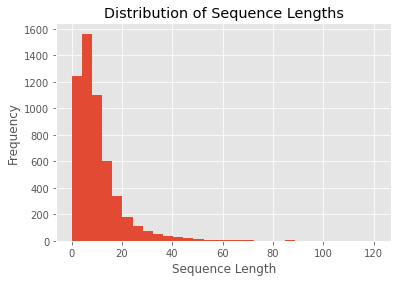

In [ ]:
# Calculate the length of each sequence in the tokens column
df['sequence_length'] = df['tokens'].apply(lambda x: len(eval(x)))  # Use eval to convert string representation of list to actual list

# Get summary statistics
length_stats = df['sequence_length'].describe().to_frame().transpose()
display(length_stats)

# Visualize the distribution of sequence lengths (optional)
plt.hist(df['sequence_length'], bins=30)
plt.title('Distribution of Sequence Lengths')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Step 2: Prepare tokenized data

# Convert tokens to sequences of integers using the embedding index
word_index = {word: idx for idx, word in enumerate(embedding_index.keys(), 1)}  # Build word index

# Convert tokens to sequences of integers
sequences = [[word_index.get(word, 0) for word in tokens] for tokens in df['tokens']]

# Define the maximum sequence length
MAX_SEQUENCE_LENGTH = 50

# Pad sequences to ensure uniform input length
sequences_padded = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

In [ ]:
# Step 3: Create the embedding matrix
embedding_dim = 300  # FastText embedding dimension is 300
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

## **Long Short-Term Memory**

In [ ]:
# Step 4: Build the LSTM model
model = Sequential()

# Add an embedding layer with pretrained FastText embeddings
model.add(Embedding(input_dim=len(word_index) + 1,
                    output_dim=embedding_dim,
                    weights=[embedding_matrix],
                    input_length=MAX_SEQUENCE_LENGTH,
                    trainable=False))                   # Set trainable=False to freeze embeddings

# Add LSTM layer
model.add(LSTM(128, return_sequences=False))

# Add a Dense output layer for binary classification
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Step 5: Train the model
# Convert 'Sentiment' to binary labels if necessary (e.g., 0 = negative, 1 = positive)
df['SentimentEnc'] = df['Sentiment'].apply(lambda x: 1 if x == 'Positive' else 0)  # Adjust for your sentiment labels

# Train the model
model.fit(sequences_padded, df['SentimentEnc'], epochs=5, batch_size=32, validation_split=0.2, verbose=0)

In [ ]:
# Step 6: Make predictions on the validation set
# Get the validation data
# Here, you can split your data into training and validation if you haven't already.
X_train, X_val, y_train, y_val = train_test_split(sequences_padded, df['SentimentEnc'], test_size=0.2, random_state=42)

# Train the model on the training set
model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose=0)

# Make predictions
y_pred_probs = model.predict(X_val)  # Get probabilities
y_pred = (y_pred_probs > 0.5).astype(int)  # Convert probabilities to binary predictions

# Step 7: Evaluate the model
print("Accuracy:", accuracy_score(y_val, y_pred))
print(classification_report(y_val, y_pred, target_names=["Negative", "Positive"]))

34/34 [==============================] - 1s 18ms/step
Accuracy: 0.9147358665430955
              precision    recall  f1-score   support

    Negative       0.93      0.91      0.92       562
    Positive       0.90      0.92      0.91       517

    accuracy                           0.91      1079
   macro avg       0.91      0.92      0.91      1079
weighted avg       0.92      0.91      0.91      1079



In [ ]:
print("Class distribution in validation set:")
print(y_val.value_counts())

Class distribution in validation set:
0    562
1    517
Name: SentimentEnc, dtype: int64


In [ ]:
print("Predicted probabilities:", y_pred_probs.flatten())
print("Predicted classes:", y_pred.flatten())

Predicted probabilities: [0.38294595 0.02542441 0.9184122  ... 0.09448025 0.03549588 0.07177474]
Predicted classes: [0 0 1 ... 0 0 0]


In [ ]:
# Step 5: Evaluate the model using precision, recall, and F1 score
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, average='micro', zero_division=0)
recall = recall_score(y_val, y_pred, average='micro', zero_division=0)
f1 = f1_score(y_val, y_pred, average='micro', zero_division=0)

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.9147358665430955
Precision: 0.9147358665430955
Recall: 0.9147358665430955
F1 Score: 0.9147358665430955


In [ ]:
conf_matrix = confusion_matrix(y_val, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[509  53]
 [ 39 478]]


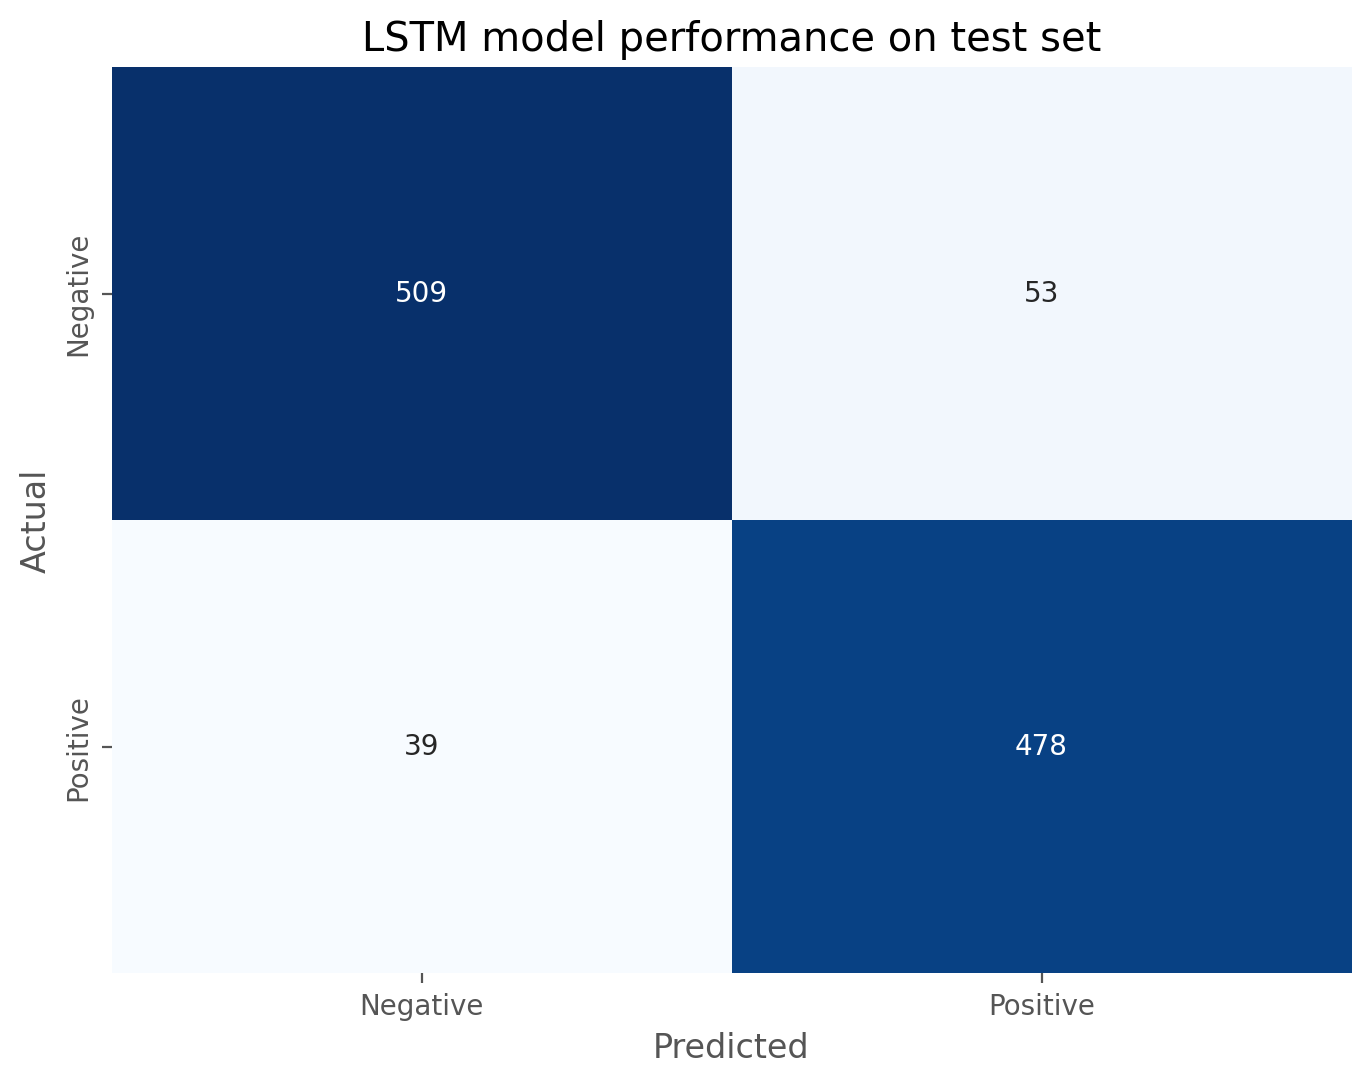

In [ ]:
# display confusion matrix
plt.figure(figsize=(8,6), dpi=200)
ax = plt.subplot()
sns.heatmap(conf_matrix, annot=True, fmt='g', ax=ax, cmap='Blues', cbar=False)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('LSTM model performance on test set')
ax.set_xticklabels(['Negative', 'Positive'])
ax.set_yticklabels(['Negative', 'Positive'])
plt.show()

## **Birdirectional LSTM**

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense

In [ ]:
# Step 2: Build and compile the Bidirectional LSTM model
model = Sequential()
model.add(Embedding(input_dim=len(word_index) + 1,
                    output_dim=embedding_dim,
                    weights=[embedding_matrix],
                    input_length=MAX_SEQUENCE_LENGTH,
                    trainable=False))
model.add(Bidirectional(LSTM(128, return_sequences=False)))  # Bidirectional LSTM layer
model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Step 3: Train the model
model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose=0)

In [ ]:
# Step 4: Make predictions
y_pred_probs = model.predict(X_val)
y_pred = (y_pred_probs > 0.5).astype(int)

# Step 5: Evaluate the model
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, average='binary', zero_division=0)
recall = recall_score(y_val, y_pred, average='binary', zero_division=0)
f1 = f1_score(y_val, y_pred, average='binary', zero_division=0)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

34/34 [==============================] - 1s 20ms/step
Accuracy: 0.7868396663577386
Precision: 0.8283752860411899
Recall: 0.7001934235976789
F1 Score: 0.7589098532494758


In [ ]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_val, y_pred)
print("Confusion Matrix:")
print(conf_matrix)


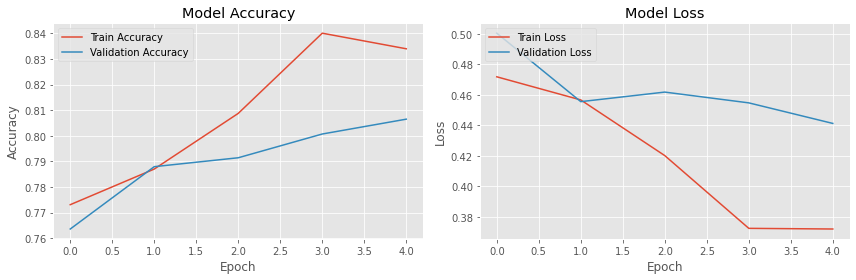

In [ ]:
# Assuming 'history' is the object returned by model.fit()
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose=0)

# Plotting training and validation accuracy
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()